In [1]:
import torch
import numpy as np
from torchsummary import summary

from data import FlagDataset
from torch.utils.data import DataLoader
from utils import get_device
from model import Encoder, Decoder

In [2]:
DEVICE = get_device()

In [3]:
flags_to_omit=["bq", "gb-nir", "sh", "sj", "bv", "bq", "mq", "gf", "nc", "re", "mf", "bl", "gp", "yt", "pm"]
flag_dataset = FlagDataset("flags", device=DEVICE, flags_to_omit=flags_to_omit)
print(f"{len(flag_dataset)} flags loaded on {flag_dataset.device}")

flag_dataloader = DataLoader(flag_dataset, batch_size=32, shuffle=True)
def cycle(iterable, n):
    while True:
        for x in iterable:
            yield x

241 flags loaded on cuda


In [4]:
latent_size = 16
encoder = Encoder(128, latent_size=latent_size).to(DEVICE)
pre_flatten_size = encoder.pre_flatten_size
print(latent_size, pre_flatten_size)
decoder = Decoder(latent_size, pre_flatten_size).to(DEVICE)

summary(encoder, (4, 128, 128))
summary(decoder, (latent_size,))

16 torch.Size([32, 2, 2])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           2,368
              ReLU-2         [-1, 64, 128, 128]               0
         MaxPool2d-3           [-1, 64, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          36,928
              ReLU-5           [-1, 64, 64, 64]               0
         MaxPool2d-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 32, 16, 16]          51,232
              ReLU-8           [-1, 32, 16, 16]               0
         MaxPool2d-9             [-1, 32, 8, 8]               0
           Conv2d-10             [-1, 32, 4, 4]          25,632
             ReLU-11             [-1, 32, 4, 4]               0
        MaxPool2d-12             [-1, 32, 2, 2]               0
           Linear-13                   [-1, 16]           2,064
          Sig

In [5]:
encoder.load_state_dict(torch.load("encoder.pth", weights_only=True))
decoder.load_state_dict(torch.load("decoder.pth", weights_only=True))

<All keys matched successfully>

In [6]:
batches = 1000

encoder.train()
decoder.train()
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-4)
running_loss = 0
print_every = 100
for i, batch in enumerate(cycle(flag_dataloader, batches)):
    optimizer.zero_grad()
    x = batch[0]
    z = encoder(x)
    x_hat = decoder(z)
    
    loss = torch.nn.functional.binary_cross_entropy(x_hat, x)
    loss.backward()
    running_loss += loss.item()
    
    if (i+1) % print_every == 0:
        print(f"Batch {i+1}: Loss {running_loss / print_every}")
        running_loss = 0
    
    optimizer.step()

Batch 100: Loss 0.1751647800207138
Batch 200: Loss 0.16655004292726516
Batch 300: Loss 0.16706354454159736
Batch 400: Loss 0.1666194212436676
Batch 500: Loss 0.16715395122766494
Batch 600: Loss 0.16726948216557502
Batch 700: Loss 0.16752774983644486
Batch 800: Loss 0.1675666895508766
Batch 900: Loss 0.1672006641328335
Batch 1000: Loss 0.1667697112262249
Batch 1100: Loss 0.16734514638781547
Batch 1200: Loss 0.16974955469369887
Batch 1300: Loss 0.16968563184142113
Batch 1400: Loss 0.16666440844535826
Batch 1500: Loss 0.1668297317624092
Batch 1600: Loss 0.1666858685016632
Batch 1700: Loss 0.16887956276535987
Batch 1800: Loss 0.1678117547929287
Batch 1900: Loss 0.16645508170127868
Batch 2000: Loss 0.16635525614023208
Batch 2100: Loss 0.168142009973526
Batch 2200: Loss 0.16684511452913284
Batch 2300: Loss 0.16757748261094094
Batch 2400: Loss 0.16717550307512283
Batch 2500: Loss 0.16693396776914596
Batch 2600: Loss 0.1667339189350605
Batch 2700: Loss 0.1672685296833515
Batch 2800: Loss 0.167

KeyboardInterrupt: 

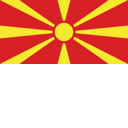

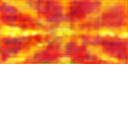

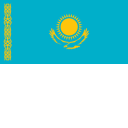

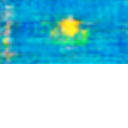

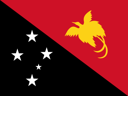

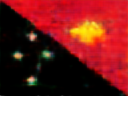

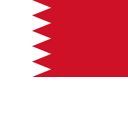

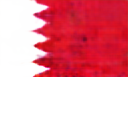

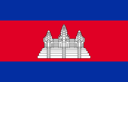

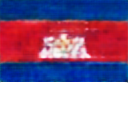

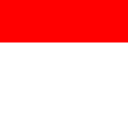

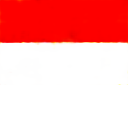

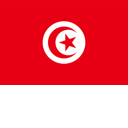

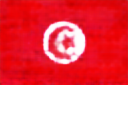

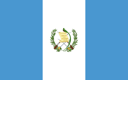

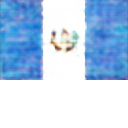

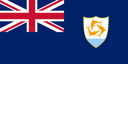

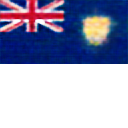

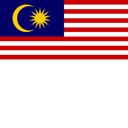

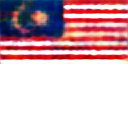

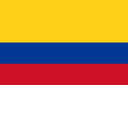

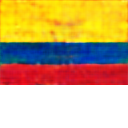

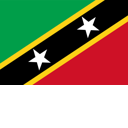

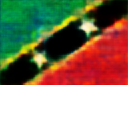

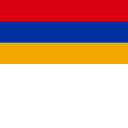

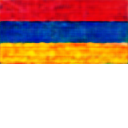

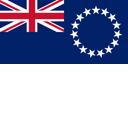

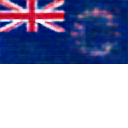

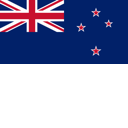

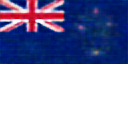

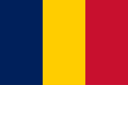

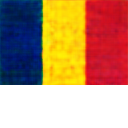

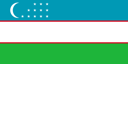

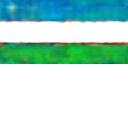

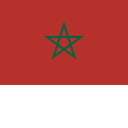

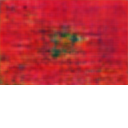

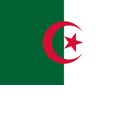

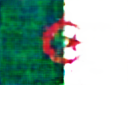

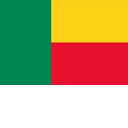

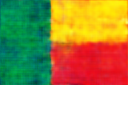

In [7]:
encoder.eval()
decoder.eval()
from PIL import Image
from torchvision.transforms import ToPILImage
to_pil = ToPILImage()

for i in range(20):
    x = flag_dataset[i][0]
    to_pil(x).show()
    z = encoder(x.unsqueeze(0))
    #z = z + (torch.randn_like(z)-0.5)*0.1
    im = decoder(z).squeeze(0)
    im = to_pil(im)
    im.show()

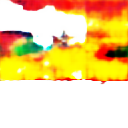

In [12]:
x = torch.rand(latent_size).to(DEVICE)
# x = x.round()
im = decoder(x.unsqueeze(0)).squeeze(0)
im = to_pil(im)
im.show()

In [13]:
torch.save(encoder.state_dict(), "encoder.pth")
torch.save(decoder.state_dict(), "decoder.pth")